In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances_argmin_min

#set font size of labels on matplotlib plots
plt.rc('font', size=16)

#set style of plots
sns.set_style('white')

#define a custom palette
sns.palplot(sns.color_palette("hls", 8))

In [2]:
df = pd.read_pickle('../players/player_stats.pkl')

In [3]:
df.head()

,Player,G,GS,MP,FG,FGA,FG%,2P,2PA,2P%,...,TOV,PF,PTS,ORtg,DRtg,Team,Season,Class,Pos,Height
0,Julian Edmonson,30,5.0,568,10.5,26.2,0.401,6.2,15.2,0.411,...,5.6,6.6,34.5,102.3,107.9,abilene-christian,2014,1.0,G,73.0
1,Jacob Lancaster,31,11.0,434,12.0,21.7,0.553,11.8,21.5,0.551,...,5.6,6.7,29.1,102.9,99.3,abilene-christian,2014,1.0,F,82.0
2,Parker Wentz,31,29.0,1040,7.7,15.7,0.491,3.2,5.6,0.576,...,3.4,4.0,24.5,124.7,107.5,abilene-christian,2014,1.0,G,69.0
3,LaDarrien Williams,16,14.0,474,8.1,21.8,0.371,6.4,16.3,0.389,...,4.2,5.2,24.4,101.2,104.1,abilene-christian,2014,1.0,G,72.0
4,Harrison Hawkins,16,16.0,481,6.8,18.1,0.374,3.7,10.4,0.353,...,6.0,5.8,24.1,100.9,108.5,abilene-christian,2014,1.0,G,72.0


## Functions

In [4]:
def guards(df):
    df = df[df['Pos'] == 'G']
    return df

In [5]:
def forwards(df):
    df = df[df['Pos'] == 'F']
    return df

In [6]:
def centers(df):
    df = df[df['Pos'] == 'C']
    return df

In [7]:
def drop_cols(df):
    df = df.drop(['G', 'GS', 'MP'], axis=1)
    return df

In [8]:
def players2018(df):
    df = df[df['Season'] == 2018]
    return df

In [9]:
def cluster_matrix_reduced(df):
#     df = df.iloc[:, 0:25]
    player = df['Player'].as_matrix()
    position = df['Pos'].as_matrix()
    X_r = df.iloc[:, 1:].drop(['Season', 'Team', 'Pos', 'FG%', '2P%', '3P%', 'FT%', 'PF', 'Height', 'Class', 'FGA', 'FG', '2PA', '3PA', 'FT', 'FTA', 'ORtg', 'DRtg', '2P'], axis=1).as_matrix()
    return X_r, player, position

In [10]:
def ID(row):
    row['ID'] = ",".join([row['Team'], str(row['Season'])])
    return row

In [11]:
def map_pos(df):
    pos_dict = {'G': 'G', 'PG': 'G', 'SG': 'G', 'F': 'F', 'SF': 'F', 'PF': 'F', 'C': 'C'}
    df['Pos'] = df['Pos'].map(pos_dict)
    return df

## Roster Counts

In [12]:
df = map_pos(df)

In [13]:
df.Pos.value_counts()

G    13324
F     8508
C     1480
Name: Pos, dtype: int64

In [14]:
df.dropna().Pos.value_counts()

G    11381
F     5600
C      489
Name: Pos, dtype: int64

In [15]:
def team_player_counts(df):
    team_player_counts = df[['Player', 'Pos', 'Team', 'Season']]
    team_player_counts = pd.pivot_table(team_player_counts, index=['Team', 'Season', 'Pos'], aggfunc='count')
    team_player_counts = team_player_counts.reset_index()
    team_player_counts.columns = ['Team', 'Season', 'Pos', 'Player_Count']
    return team_player_counts

In [16]:
team_player_counts = team_player_counts(df)

In [17]:
team_player_counts.head()

,Team,Season,Pos,Player_Count
0,abilene-christian,2014,F,5
1,abilene-christian,2014,G,7
2,abilene-christian,2015,F,5
3,abilene-christian,2015,G,9
4,abilene-christian,2016,F,5


In [18]:
df2018 = players2018(df)

In [19]:
df2018.groupby('Pos').mean()

,G,GS,MP,FG,FGA,FG%,2P,2PA,2P%,3P,...,STL,BLK,TOV,PF,PTS,ORtg,DRtg,Season,Class,Height
Pos,,,,,,,,,,,,,,,,,,,,,
C,24.617188,11.214844,382.992188,6.950391,13.555469,0.525565,6.680859,12.610938,0.541125,0.269922,...,0.990625,2.808984,3.675781,8.706250,17.417969,102.475391,102.467969,2018.0,0.796875,82.187500
F,25.695214,12.590050,475.289673,6.887028,14.667632,0.470782,5.729786,10.967947,0.516275,1.156108,...,1.376763,1.645529,3.462217,7.107053,18.460202,102.319018,103.553589,2018.0,0.726700,79.594458
G,25.249795,13.242412,558.977030,6.275267,15.991017,0.392270,3.779614,8.270919,0.449407,2.495939,...,1.920837,0.394011,3.661567,4.715997,18.447621,98.706932,105.967473,2018.0,0.726415,74.596390


## Reduced DateFrame

In [20]:
# Features to Cluster Centers
reduced_df_cols = ['Player', 'MP', 'FT', '2P', '3P', 'TRB', 'AST', 'STL',
                     'BLK', 'PTS', 'Team', 'Season', 'Pos']

# ['Player', 'MP', 'FT', 'FTA', 'FT%', '2P', '2PA', '2P%', '3P', '3PA', '3P%', 'TRB', 'AST', 'STL',
#                      'BLK', 'TOV', 'PTS', 'Team', 'Season', 'Pos', 'Height']

df_r = df[reduced_df_cols]

c_reduced_df_cols = ['Player', 'MP', '2P', '3P', 'TRB', 'AST', 'STL',
                     'BLK', 'TOV', 'PTS', 'Team', 'Season', 'Pos', 'Height']

c_df_r = df[c_reduced_df_cols]

# Features to Cluster Forwards
f_reduced_df_cols = ['Player', 'MP', '2P', '2PA', '3P', '3PA', 'TRB', 'AST', 'STL',
                     'BLK', 'TOV', 'PTS', 'Team', 'Season', 'Pos']

f_df_r = df[f_reduced_df_cols]

# Features to Cluster Guards
g_reduced_df_cols = ['Player', 'MP', '3P', 'AST', 'STL', 'TOV',
                     'PTS', 'TRB', 'Team', 'Season', 'Pos']

g_df_r = df[g_reduced_df_cols]

## Deal with NaNs

In [21]:
# Drop NaNs from reduced DataFrame
df_r.Pos.value_counts()

G    13324
F     8508
C     1480
Name: Pos, dtype: int64

In [22]:
df_r.dropna().Pos.value_counts()

G    13270
F     8461
C     1475
Name: Pos, dtype: int64

In [23]:
# Drop NaNs from reduced DataFrame
df_r = df_r.dropna()
c_df_r = centers(c_df_r.dropna())
g_df_r = guards(g_df_r.dropna())
f_df_r = forwards(f_df_r.dropna())

## Vectorize dfs

In [24]:
def cluster_matrix(df):
    player = df['Player'].as_matrix()
    position = df['Pos'].as_matrix()
    X = df.drop(['Player', 'MP', 'Team', 'Season', 'Pos'], axis=1).as_matrix()
    return X, player, position

In [25]:
X, player, position = cluster_matrix(df_r)
X_c, player_c, position_c = cluster_matrix(c_df_r)
X_f, player_f, position_f = cluster_matrix(f_df_r)
X_g, player_g, position_g = cluster_matrix(g_df_r)

In [26]:
X_cols = df_r.drop(['Player', 'MP', 'Team', 'Season', 'Pos'], axis=1).columns.tolist()
X_c_cols = c_df_r.drop(['Player', 'MP', 'Team', 'Season', 'Pos'], axis=1).columns.tolist()
X_f_cols = f_df_r.drop(['Player', 'MP', 'Team', 'Season', 'Pos'], axis=1).columns.tolist()
X_g_cols = g_df_r.drop(['Player', 'MP', 'Team', 'Season', 'Pos'], axis=1).columns.tolist()

## Standardize

In [27]:
scale = StandardScaler()
X = scale.fit_transform(X)
X_c = scale.fit_transform(X_c)
X_f = scale.fit_transform(X_f)
X_g = scale.fit_transform(X_g)

In [28]:
# scale = StandardScaler()
# X_f = scale.fit_transform(X_f)

In [29]:
# scale = StandardScaler()
# X_g = scale.fit_transform(X_g)

## Cluster

In [30]:
Ks = range(2, 10, 1)
km = [KMeans(n_clusters=i) for i in Ks]
sil_score = [silhouette_score(X, km[i].fit(X).labels_) for i in range(len(km))]
sil_score_c = [silhouette_score(X_c, km[i].fit(X_c).labels_) for i in range(len(km))]
sil_score_f = [silhouette_score(X_f, km[i].fit(X_f).labels_) for i in range(len(km))]
sil_score_g = [silhouette_score(X_g, km[i].fit(X_g).labels_) for i in range(len(km))]

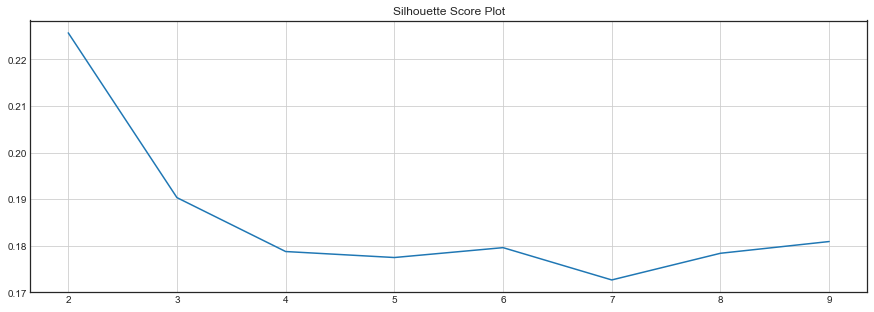

In [31]:
fig = plt.figure(figsize=(15, 5))
plt.plot(Ks, sil_score)
plt.grid(True)
plt.title('Silhouette Score Plot');

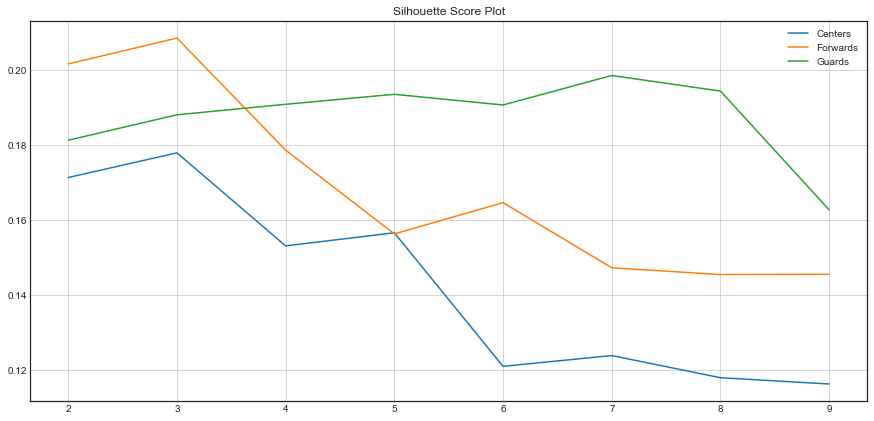

In [32]:
fig = plt.figure(figsize=(15, 7))
plt.plot(Ks, sil_score_c)
plt.plot(Ks, sil_score_f)
plt.plot(Ks, sil_score_g)
plt.legend(['Centers', 'Forwards', 'Guards'], loc='best')
plt.grid(True)
plt.title('Silhouette Score Plot');

In [33]:
ckmeans = KMeans(n_clusters=3, init='k-means++', n_init=20, max_iter=500, tol=0.0001,
                        precompute_distances='auto', verbose=0, random_state=None,
                        copy_x=True, n_jobs=-1, algorithm='auto')
ckmeans.fit(X_c);

In [34]:
fkmeans = KMeans(n_clusters=3, init='k-means++', n_init=20, max_iter=500, tol=0.0001,
                        precompute_distances='auto', verbose=0, random_state=None,
                        copy_x=True, n_jobs=-1, algorithm='auto')
fkmeans.fit(X_f);

In [35]:
gkmeans = KMeans(n_clusters=7, init='k-means++', n_init=20, max_iter=500, tol=0.0001,
                        precompute_distances='auto', verbose=0, random_state=None,
                        copy_x=True, n_jobs=-1, algorithm='auto')
gkmeans.fit(X_g);

In [36]:
cclusters = ckmeans.labels_
ccluster_centers = ckmeans.cluster_centers_ 
fclusters = fkmeans.labels_
fcluster_centers = fkmeans.cluster_centers_ 
gclusters = gkmeans.labels_
gcluster_centers = gkmeans.cluster_centers_ 

In [37]:
#sorting to get top 10 feature indexes for each centroid
ccluster_ind = np.argsort(ccluster_centers, axis=1)
top = 3
tops = np.array([])
for row in ccluster_ind[:,:top]:
    cluster_tops = np.array([])
    for col in row:
        cluster_tops = np.append(cluster_tops, X_c_cols[col])
    tops = np.append(tops, cluster_tops)

tops.reshape(-1,top)

array([['3P', 'BLK', 'Height'],
       ['PTS', '2P', 'TRB'],
       ['TRB', 'BLK', 'Height']], dtype='<U32')

In [180]:
center_labels_dict = {0: 'All Team Centers', 1: 'B Team Centers', 2: 'Shooting Centers'}

In [38]:
#sorting to get top 10 feature indexes for each centroid
fcluster_ind = np.argsort(fcluster_centers, axis=1)
top = 3
tops = np.array([])
for row in ccluster_ind[:,:top]:
    cluster_tops = np.array([])
    for col in row:
        cluster_tops = np.append(cluster_tops, X_f_cols[col])
    tops = np.append(tops, cluster_tops)

tops.reshape(-1,top)

array([['2PA', 'AST', 'TOV'],
       ['BLK', '2P', '3P'],
       ['3P', 'AST', 'TOV']], dtype='<U32')

In [92]:
forward_labels_dict = {0: 'Deep Forwards', 1: 'Versatile Forwards', 2: 'Supporting Forwards'}

In [39]:
#sorting to get top 10 feature indexes for each centroid
gcluster_ind = np.argsort(gcluster_centers, axis=1)
top = 3
tops = np.array([])
for row in gcluster_ind[:,:top]:
    cluster_tops = np.array([])
    for col in row:
        cluster_tops = np.append(cluster_tops, X_g_cols[col])
    tops = np.append(tops, cluster_tops)

tops.reshape(-1,top)

array([['AST', 'TOV', 'TRB'],
       ['3P', 'TRB', 'PTS'],
       ['AST', 'STL', 'TRB'],
       ['PTS', '3P', 'AST'],
       ['3P', 'AST', 'PTS'],
       ['3P', 'TRB', 'PTS'],
       ['PTS', '3P', 'STL']], dtype='<U32')

In [185]:
guard_labels_dict = {0: 'All team Guards', 1: 'Supporting Guards', 2: 'Utility 3 Point Shooter', 3: 'B Team Guard', 4: 'Rebounding Guard', 5: 'Utility Thief', 6: 'Benchwarmers'}

In [40]:
pd.DataFrame(ccluster_centers, columns=X_c_cols)

,2P,3P,TRB,AST,STL,BLK,TOV,PTS,Height
0,0.897317,-0.156796,0.462359,0.218109,0.165465,0.094031,0.130981,0.837376,0.096542
1,-0.633994,-0.229437,-0.281209,-0.270231,-0.136125,-0.011655,-0.083222,-0.695350,-0.015166
2,-0.333492,3.244333,-0.597639,1.006431,0.118459,-0.547968,-0.135974,0.659963,-0.532631


In [41]:
pd.DataFrame(fcluster_centers, columns=X_f_cols)

,2P,2PA,3P,3PA,TRB,AST,STL,BLK,TOV,PTS
0,-0.591240,-0.602258,1.389665,1.434343,-0.507642,0.320343,0.042384,-0.439158,-0.184775,0.308171
1,0.959626,0.903182,-0.348392,-0.396468,0.466935,0.077469,0.107482,0.249571,0.284765,0.703097
2,-0.562957,-0.503829,-0.463131,-0.443481,-0.148970,-0.254544,-0.124751,0.015720,-0.161757,-0.833623


In [42]:
pd.DataFrame(gcluster_centers, columns=X_g_cols)

,3P,AST,STL,TOV,PTS,TRB
0,0.669336,-0.233075,-0.063356,-0.133034,0.588344,-0.122204
1,-0.355607,1.220405,0.272022,0.264075,-0.102547,-0.170556
2,4.796622,-0.620723,-0.399093,0.204643,3.180207,0.182637
3,-0.572518,-0.476233,-0.195803,-0.169025,-0.809206,-0.324420
4,-0.655093,-0.490481,-0.021512,0.065643,-0.071644,1.779952
5,-1.111836,0.694024,15.650179,0.760368,0.355788,0.106601
6,-0.970635,-0.260705,-0.834311,12.267066,-1.378249,1.069623


In [43]:
topics = c_df_r.Player
for clust in np.unique(ckmeans.labels_):
    mask = ckmeans.labels_ == clust
    print('Cluster {}: {}\n'.format(clust, random.sample(list(topics[mask]), 10)))

Cluster 0: ['Cady Lalanne', 'Justin McBride', 'Cady Lalanne', 'AJ West', 'Davis Rozitis', 'Brandon Goode', 'Ricmonds Vilde', 'KC Caudill', 'Kelvin Jones', 'Tim Kempton']

Cluster 1: ['Nikola Scekic', 'Travis Avery', 'Javan Mitchell', 'Kameron Rooks', 'Anton Larsen', 'Ivan Jurkovic', 'Asauhn Dixon-Tatum', 'Fallou Ndoye', 'Schuyler Rimmer', 'Joseph Uchebo']

Cluster 2: ['Erik Poulsen', 'Nate Fowler', 'Austin Gillmann', 'Brendan Leonard', 'Abdul Ahmed', 'Garrett Mullis', 'Frank Kaminsky', 'Tyler Hadden', 'Tommy Hamilton', 'Menno Dijkstra']



In [44]:
topics = f_df_r.Player
for clust in np.unique(fkmeans.labels_):
    mask = fkmeans.labels_ == clust
    print('Cluster {}: {}\n'.format(clust, random.sample(list(topics[mask]), 10)))

Cluster 0: ['Andy Van Vliet', 'Hari Hall', 'Jermaine Crumpton', 'Felipe Haase', 'Will Saunders', 'Chris Porter-Bunton', 'A.J. Turner', 'Lester Wilson', 'Shannon Hale', 'Deng Adel']

Cluster 1: ['Tommy Carpenter', 'Adom Jacko', 'Ryan Spangler', 'Tyler Roberson', 'Jake Zuilhof', 'Jordan Tolbert', 'Jason Burnell', 'JayVaughn Pinkston', 'Perry Ellis', "Del'Vin Dickerson"]

Cluster 2: ['Nick Gorski', 'Jamari Traylor', 'Corey Hall', 'Marquis Salmon', 'Okey Ukah', 'Derek Sloan', 'Omar Habwe', 'Pete Kpan', 'Aaron Leblanc', 'Jalen King']



In [45]:
topics = g_df_r.Player
for clust in np.unique(gkmeans.labels_):
    mask = gkmeans.labels_ == clust
    print('Cluster {}: {}\n'.format(clust, random.sample(list(topics[mask]), 10)))

Cluster 0: ['Isaiah Cousins', 'Jeremiah Martin', 'T.J. Wallace', 'Keith Hornsby', 'Gavin Peppers', 'Jared Klein', 'Avry Holmes', 'Justin Anderson', 'Dion Nesmith', 'Michael Mayhew']

Cluster 1: ['Justin Coleman', 'Ryan Boatright', 'Madison Jones', 'Hunter Eggers', 'Nick Coppola', 'Tyler Jenkins', 'Joseph Gripper', 'Demetrius Troy', 'Justin Jenifer', 'Taj Owens']

Cluster 2: ['Zach Yoshor', 'J.T. Trauber', 'Lance Richard', 'C.J. Holmes', 'Matt Ratto', 'Jacob Redding', 'Nick Singleton', 'Jarett Upchurch', 'Kyle Stroder', 'Keith Benford']

Cluster 3: ['Eli Stalzer', 'Matteo Bellusci', 'Stephen Prendergast', 'Lexx Edwards', 'Jalen Palm', 'Shaunessy Smith', 'Todd Hughes', 'Charlie Noebel', 'Luka Vasic', 'Khalid Lewis']

Cluster 4: ['Kyle Gonzalez', 'Miles Bridges', 'Erten Gazi', 'Thomas Blake', 'Christian Harrison', 'Carlitos Anderson', 'Brian Pegg', 'Loren Brill', 'Zach Altany', 'Khyler Fields']

Cluster 5: ['Peyton Robbins', 'Kirkland Humphrey', 'Andre Chatfield', 'Ky Feldman', 'David Goo

## Just 2018

In [46]:
df2018 = players2018(df)

In [47]:
c_df2018 = centers(df2018)
f_df2018 = forwards(df2018)
g_df2018 = guards(df2018)

In [48]:
# Features to Cluster Centers
reduced_df2018_cols = ['Player', 'MP', 'FT', '2P', '3P', 'TRB', 'AST', 'STL',
                     'BLK', 'PTS', 'Team', 'Season', 'Pos']

df2018_r = df[reduced_df_cols]

c_reduced_df2018_cols = ['Player', 'MP', '2P', '3P', 'TRB', 'AST', 'STL',
                     'BLK', 'TOV', 'PTS', 'Team', 'Season', 'Pos', 'Height']

c_df2018_r = df[c_reduced_df_cols]

# Feaatures to Cluster Forwards
f_reduced_df2018_cols = ['Player', 'MP', '2P', '2PA', '3P', '3PA', 'TRB', 'AST', 'STL',
                     'BLK', 'TOV', 'PTS', 'Team', 'Season', 'Pos']

f_df2018_r = df[f_reduced_df_cols]

# Features to Cluster Guards
g_reduced_df2018_cols = ['Player', 'MP', '3P', 'AST', 'STL', 'TOV',
                     'PTS', 'TRB', 'Team', 'Season', 'Pos']

g_df2018_r = df[g_reduced_df_cols]

In [49]:
# Drop NaNs from reduced DataFrame
df2018_r = df2018_r.dropna()
c_df2018_r = centers(c_df2018_r.dropna())
g_df2018_r = guards(g_df2018_r.dropna())
f_df2018_r = forwards(f_df2018_r.dropna())

In [50]:
X2018, player2018, position2018 = cluster_matrix(df2018_r)
X2018_c, player2018_c, position2018_c = cluster_matrix(c_df2018_r)
X2018_f, player2018_f, position2018_f = cluster_matrix(f_df2018_r)
X2018_g, player2018_g, position2018_g = cluster_matrix(g_df2018_r)

In [51]:
X2018_cols = df2018_r.drop(['Player', 'MP', 'Team', 'Season', 'Pos'], axis=1).columns.tolist()
X2018_c_cols = c_df2018_r.drop(['Player', 'MP', 'Team', 'Season', 'Pos'], axis=1).columns.tolist()
X2018_f_cols = f_df2018_r.drop(['Player', 'MP', 'Team', 'Season', 'Pos'], axis=1).columns.tolist()
X2018_g_cols = g_df2018_r.drop(['Player', 'MP', 'Team', 'Season', 'Pos'], axis=1).columns.tolist()

In [52]:
scale = StandardScaler()
X2018 = scale.fit_transform(X2018)
X2018_c = scale.fit_transform(X2018_c)
X2018_f = scale.fit_transform(X2018_f)
X2018_g = scale.fit_transform(X2018_g)

In [53]:
Ks = range(2, 10, 1)
km = [KMeans(n_clusters=i) for i in Ks]
sil_score2018 = [silhouette_score(X2018, km[i].fit(X2018).labels_) for i in range(len(km))]
sil_score_c2018 = [silhouette_score(X2018_c, km[i].fit(X2018_c).labels_) for i in range(len(km))]
sil_score_f2018 = [silhouette_score(X2018_f, km[i].fit(X2018_f).labels_) for i in range(len(km))]
sil_score_g2018 = [silhouette_score(X2018_g, km[i].fit(X2018_g).labels_) for i in range(len(km))]

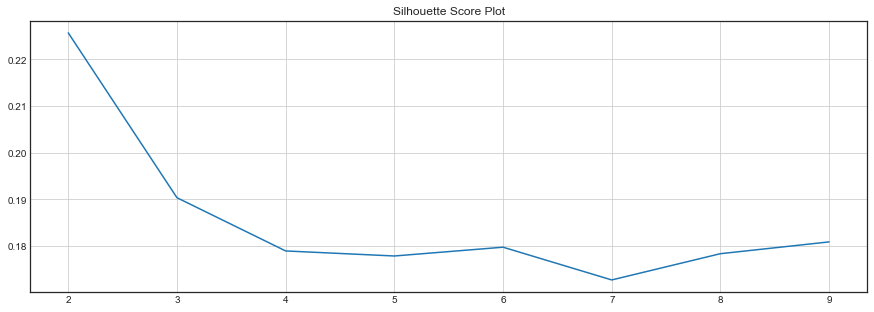

In [54]:
fig = plt.figure(figsize=(15, 5))
plt.plot(Ks, sil_score2018)
plt.grid(True)
plt.title('Silhouette Score Plot');

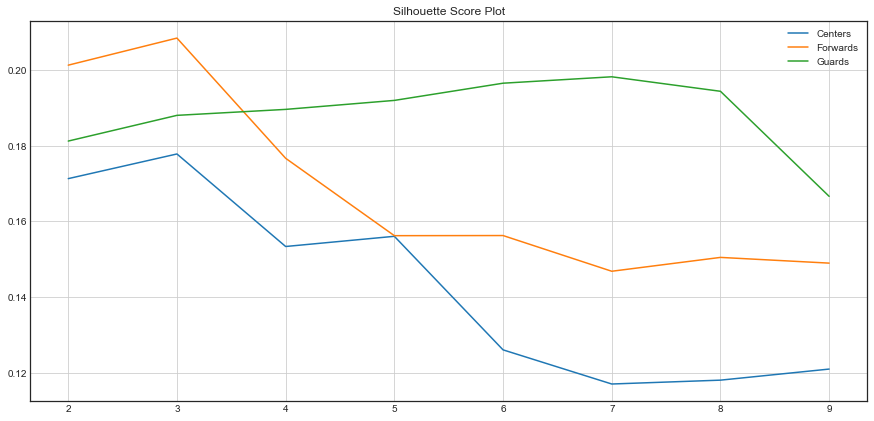

In [55]:
fig = plt.figure(figsize=(15, 7))
plt.plot(Ks, sil_score_c2018)
plt.plot(Ks, sil_score_f2018)
plt.plot(Ks, sil_score_g2018)
plt.legend(['Centers', 'Forwards', 'Guards'], loc='best')
plt.grid(True)
plt.title('Silhouette Score Plot');

## Forget about 2018

In [56]:
tSNE = TSNE(n_components=2)
X_c_tSNE = tSNE.fit_transform(X_c)
X_f_tSNE = tSNE.fit_transform(X_f)
X_g_tSNE = tSNE.fit_transform(X_g)

In [57]:
X_c_df = pd.DataFrame(X_c_tSNE, columns=['x','y'])
X_f_df = pd.DataFrame(X_f_tSNE, columns=['x','y'])
X_g_df = pd.DataFrame(X_g_tSNE, columns=['x','y'])

In [187]:
X_c_df['label'] = cclusters
X_f_df['label'] = fclusters
X_g_df['label'] = gclusters

X_c_df['label_name'] = X_c_df['label'].map(center_labels_dict)
X_f_df['label_name'] = X_f_df['label'].map(forward_labels_dict)
X_g_df['label_name'] = X_g_df['label'].map(guard_labels_dict)

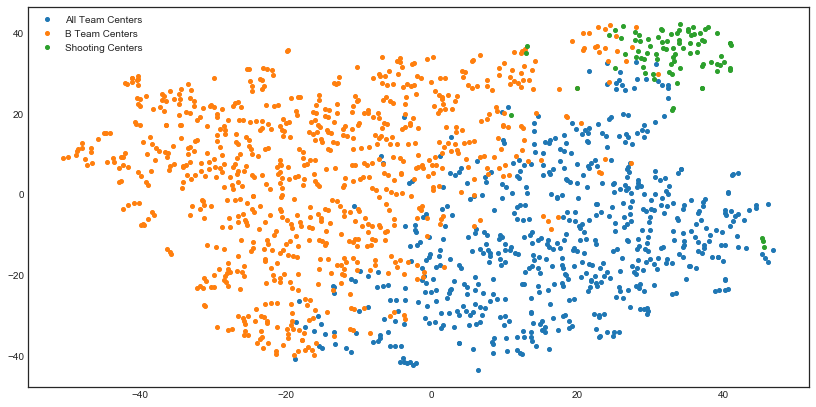

In [182]:
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111)

groups = X_c_df.groupby('label_name')

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=4, label=name)
ax.legend()

plt.show()

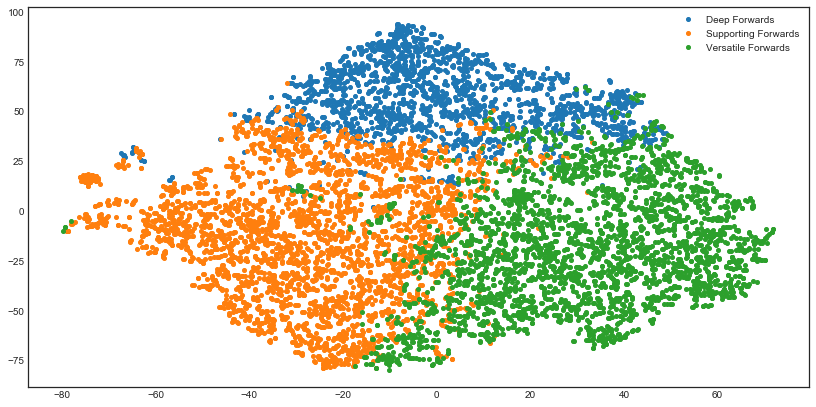

In [183]:
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111)

groups = X_f_df.groupby('label_name')

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=4, label=name)
ax.legend()

plt.show()

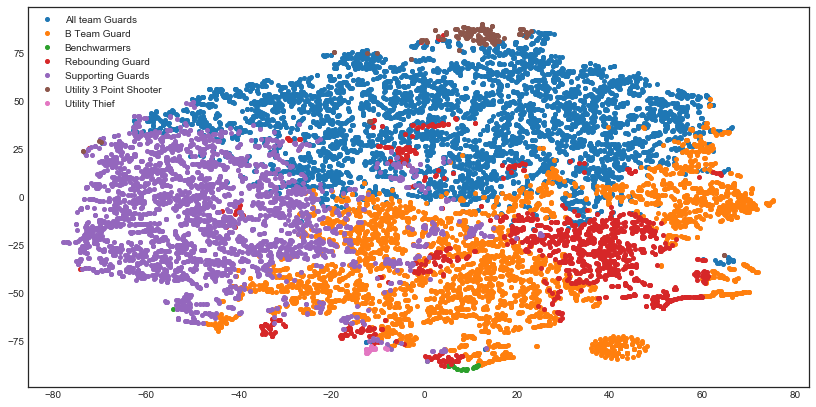

In [188]:
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111)

groups = X_g_df.groupby('label_name')

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=4, label=name)
ax.legend()

plt.show()

In [75]:
tSNE3 = TSNE(n_components=3)
X_c_tSNE3 = tSNE3.fit_transform(X_c)

In [76]:
tSNE3 = TSNE(n_components=3)
X_f_tSNE3 = tSNE3.fit_transform(X_f)

In [77]:
tSNE3 = TSNE(n_components=3)
X_g_tSNE3 = tSNE3.fit_transform(X_g)

In [189]:
X3_c_df = pd.DataFrame(X_c_tSNE3, columns=['x', 'y', 'z'])
X3_f_df = pd.DataFrame(X_f_tSNE3, columns=['x', 'y', 'z'])
X3_g_df = pd.DataFrame(X_g_tSNE3, columns=['x', 'y', 'z'])

X3_c_df['label'] = cclusters
X3_f_df['label'] = fclusters
X3_g_df['label'] = gclusters

X3_c_df['label_name'] = X3_c_df['label'].map(center_labels_dict)
X3_f_df['label_name'] = X3_f_df['label'].map(forward_labels_dict)
X3_g_df['label_name'] = X3_g_df['label'].map(guard_labels_dict)

In [99]:
def tSNE_3dscatter(df, title):
#     tSNE = TSNE(n_components=3) 
#     X_tSNE = tSNE.fit_transform(X)
    fig = plt.figure(figsize=(14,10))
    ax1 = fig.add_subplot(111,projection='3d')
    
#     df = pd.DataFrame(X_tSNE, columns=['x','y', 'z'])
#     df['label'] = labels
    groups = df.groupby('label_name')
    for name, group in groups:
        ax1.scatter(group.x, group.y, group.z, label=name)
    ax1.legend(loc='best')
    
#     ax2 = fig.add_subplot(122,projection='3d')
#     for name, group in groups:
#         ax2.scatter(group.x, group.y, group.z, label=name)
#     ax2.view_init(azim=30)
#     ax2.legend(loc='best')
    
    plt.title('{}: 3-Dimensional tSNE Plot'.format(title))

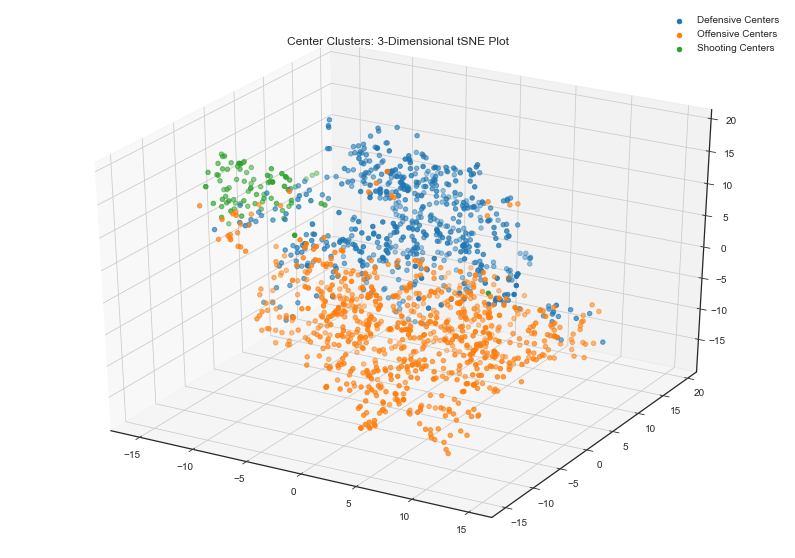

In [100]:
tSNE_3dscatter(X3_c_df, 'Center Clusters')

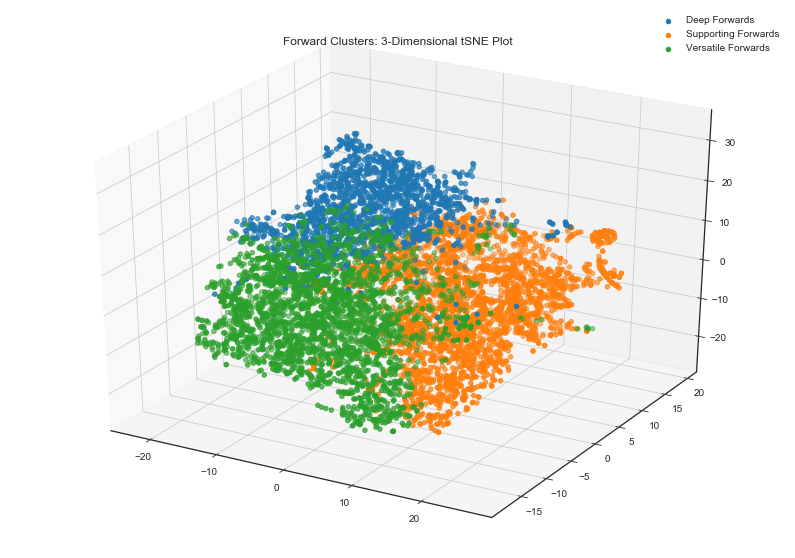

In [101]:
tSNE_3dscatter(X3_f_df, 'Forward Clusters')

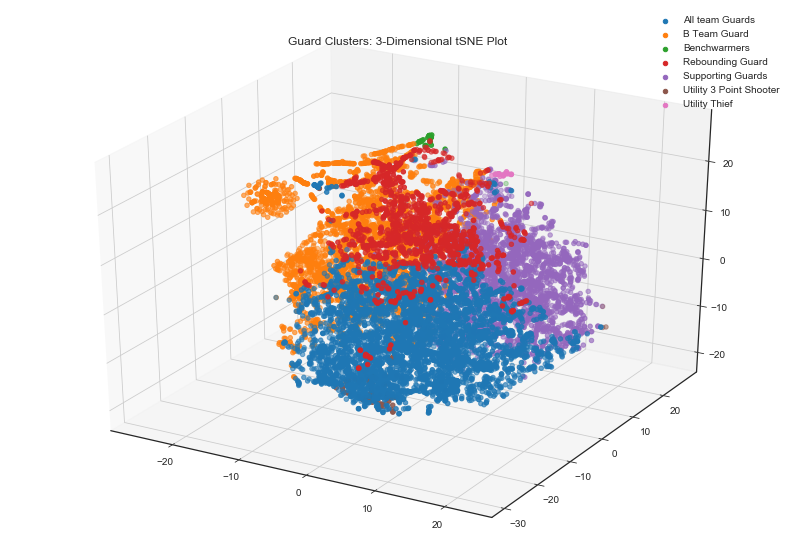

In [190]:
tSNE_3dscatter(X3_g_df, 'Guard Clusters')

In [83]:
def tSNE_3dscatter_view(df, title):
#     tSNE = TSNE(n_components=3) 
#     X_tSNE = tSNE.fit_transform(X)
    fig = plt.figure(figsize=(14,10))
    ax1 = fig.add_subplot(111,projection='3d')
    
#     df = pd.DataFrame(X_tSNE, columns=['x','y', 'z'])
#     df['label'] = labels
    groups = df.groupby('label')
    for name, group in groups:
        ax1.scatter(group.x, group.y, group.z, label=name)
    ax1.view_init(azim=30)
    ax1.legend(loc='best')
    
    plt.title('{}: 3-Dimensional tSNE Plot'.format(title))

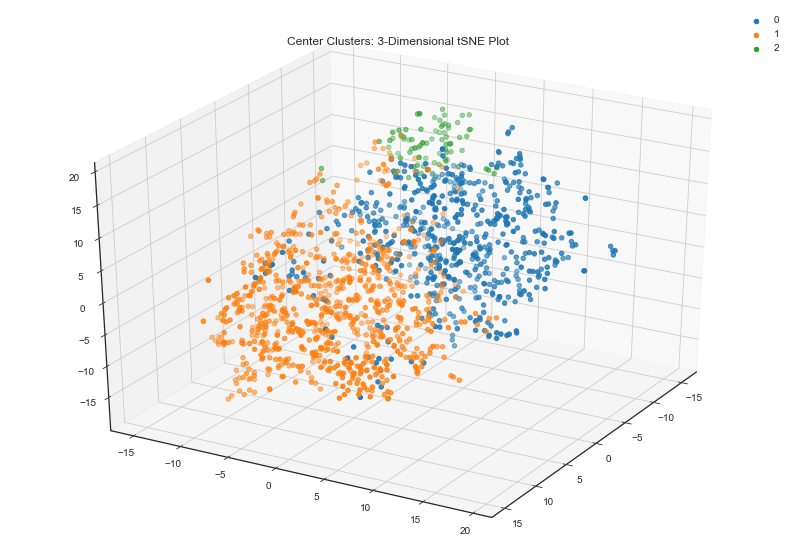

In [84]:
tSNE_3dscatter_view(X3_c_df, 'Center Clusters')

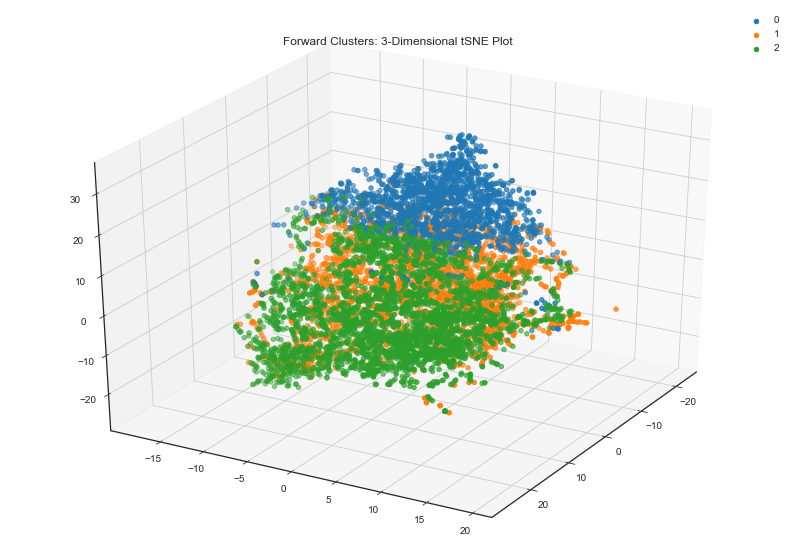

In [85]:
tSNE_3dscatter_view(X3_f_df, 'Forward Clusters')

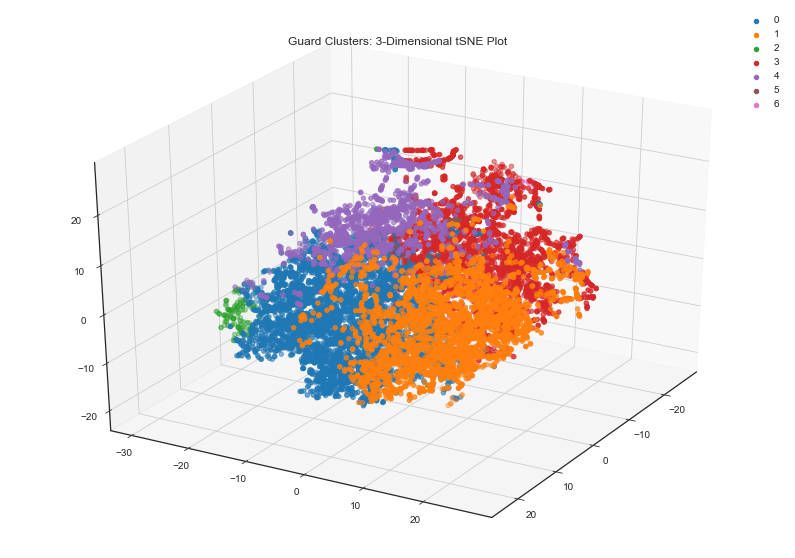

In [86]:
tSNE_3dscatter_view(X3_g_df, 'Guard Clusters')

## Cluster Representatives

In [87]:
def centroid_rep(X, y):
    return pairwise_distances_argmin_min(X, y)

In [88]:
centroid_rep(X_c, ccluster_centers)

(array([0, 1, 0, ..., 0, 1, 1]),
 array([3.38161436, 2.73126676, 1.49608144, ..., 1.65442218, 2.74075714,
        3.1937475 ]))

In [89]:
centroid_rep(X_f, fcluster_centers)

(array([1, 1, 1, ..., 1, 0, 2]),
 array([2.91093288, 1.90039357, 1.63049288, ..., 1.417167  , 2.13869077,
        1.09207048]))

In [90]:
centroid_rep(X_g, gcluster_centers)

(array([0, 0, 1, ..., 0, 3, 3]),
 array([1.39958927, 0.95280738, 1.19294013, ..., 1.26114593, 1.17028706,
        1.12978356]))

## Recompose player df with clusters

In [107]:
centers_df = c_df_r
centers_df['Cluster'] = cclusters
centers_df['Cluster_names'] = centers_df['Cluster'].map(center_labels_dict)
centers_df.head()

,Player,MP,2P,3P,TRB,AST,STL,BLK,TOV,PTS,Team,Season,Pos,Height,Cluster,Cluster_names
13,Zach Moer,52,8.2,0.0,9.4,5.9,1.2,4.7,5.9,24.7,air-force,2014,C,83.0,0,Defensive Centers
19,Darrius Parker,238,5.7,0.5,9.8,3.3,1.0,1.5,3.1,17.7,air-force,2014,C,79.0,1,Offensive Centers
36,Pat Forsythe,595,7.2,0.0,11.6,1.7,1.4,3.4,4.8,17.2,akron,2014,C,83.0,0,Defensive Centers
37,Isaiah Johnson,414,6.8,0.0,12.7,1.8,1.2,4.0,2.8,17.2,akron,2014,C,82.0,1,Offensive Centers
49,Justin Banks,408,6.6,0.0,17.7,0.9,1.0,4.4,3.0,17.7,alabama-am,2014,C,85.0,0,Defensive Centers


In [156]:
centers_df.groupby('Cluster')['MP', '2P', '3P', 'AST', 'STL', 'TOV', 'PTS', 'TRB', 'BLK'].mean().round()

,MP,2P,3P,AST,STL,TOV,PTS,TRB,BLK
Cluster,,,,,,,,,
0,548.0,9.0,0.0,2.0,1.0,4.0,24.0,16.0,3.0
1,273.0,4.0,0.0,1.0,1.0,4.0,12.0,12.0,3.0
2,489.0,5.0,3.0,3.0,1.0,3.0,22.0,11.0,2.0


In [130]:
centers_df[(centers_df['Cluster'] == 0) & (centers_df['Season'] == 2018)].sort_values(by='MP', axis=0, ascending=False).iloc[0, :]

Player                Jock Landale
MP                            1200
2P                            15.6
3P                             0.2
TRB                           19.2
AST                            3.8
STL                            0.7
BLK                            1.9
TOV                            4.4
PTS                           39.9
Team                saint-marys-ca
Season                        2018
Pos                              C
Height                          83
Cluster                          0
Cluster_names    Defensive Centers
Name: 22665, dtype: object

In [131]:
centers_df[(centers_df['Cluster'] == 1) & (centers_df['Season'] == 2018)].sort_values(by='MP', axis=0, ascending=False).iloc[0, :]

Player                  JD Wallace
MP                            1055
2P                             5.6
3P                               0
TRB                           15.1
AST                            0.5
STL                            1.6
BLK                              2
TOV                            1.8
PTS                           13.8
Team                  prairie-view
Season                        2018
Pos                              C
Height                          81
Cluster                          1
Cluster_names    Offensive Centers
Name: 22428, dtype: object

In [132]:
centers_df[(centers_df['Cluster'] == 2) & (centers_df['Season'] == 2018)].sort_values(by='MP', axis=0, ascending=False).iloc[0, :]

Player               Thomas Welsh
MP                           1096
2P                              6
3P                            2.3
TRB                          18.3
AST                           2.3
STL                           1.1
BLK                           1.5
TOV                           1.7
PTS                          21.3
Team                         ucla
Season                       2018
Pos                             C
Height                         84
Cluster                         2
Cluster_names    Shooting Centers
Name: 23444, dtype: object

In [133]:
forwards_df = f_df_r
forwards_df['Cluster'] = fclusters
forwards_df['Cluster_names'] = forwards_df['Cluster'].map(forward_labels_dict)
forwards_df.head()

,Player,MP,2P,2PA,3P,3PA,TRB,AST,STL,BLK,TOV,PTS,Team,Season,Pos,Cluster,Cluster_names
1,Jacob Lancaster,434,11.8,21.5,0.1,0.1,19.6,1.0,1.0,5.0,5.6,29.1,abilene-christian,2014,F,1,Versatile Forwards
5,James Pegues,445,7.2,15.8,0.1,0.8,13.4,2.1,2.9,0.4,6.1,20.9,abilene-christian,2014,F,1,Versatile Forwards
7,Alexsander Milosavljevic,127,7.9,14.9,0.0,0.5,15.4,1.4,0.0,1.4,4.7,17.7,abilene-christian,2014,F,1,Versatile Forwards
8,Austin Cooke,914,2.1,4.3,3.0,7.5,11.4,3.9,1.9,0.3,1.9,15.8,abilene-christian,2014,F,0,Deep Forwards
10,Riley Payne,584,3.9,8.3,0.0,0.0,7.9,2.4,1.8,0.3,3.3,11.1,abilene-christian,2014,F,2,Supporting Forwards


In [154]:
forwards_df.groupby('Cluster')['MP', '2P', '2PA', '3P', '3PA', 'AST', 'STL', 'TOV', 'PTS', 'TRB'].mean().round()

,MP,2P,2PA,3P,3PA,AST,STL,TOV,PTS,TRB
Cluster,,,,,,,,,,
0,534.0,4.0,8.0,3.0,10.0,3.0,1.0,3.0,20.0,10.0
1,591.0,9.0,16.0,0.0,2.0,2.0,2.0,4.0,24.0,15.0
2,305.0,4.0,8.0,0.0,1.0,2.0,1.0,3.0,11.0,12.0


In [134]:
forwards_df[(forwards_df['Cluster'] == 0) & (forwards_df['Season'] == 2018)].sort_values(by='MP', axis=0, ascending=False).iloc[0, :]

Player           Oshae Brissett
MP                         1411
2P                          4.7
2PA                        12.8
3P                          2.4
3PA                         7.3
TRB                        14.4
AST                         1.5
STL                         1.9
BLK                         1.3
TOV                           3
PTS                        24.3
Team                   syracuse
Season                     2018
Pos                           F
Cluster                       0
Cluster_names     Deep Forwards
Name: 23144, dtype: object

In [135]:
forwards_df[(forwards_df['Cluster'] == 1) & (forwards_df['Season'] == 2018)].sort_values(by='MP', axis=0, ascending=False).iloc[0, :]

Player               Justin Johnson
MP                             1314
2P                              8.4
2PA                            15.4
3P                              2.1
3PA                             4.9
TRB                            15.7
AST                             2.1
STL                             1.2
BLK                             1.2
TOV                             2.5
PTS                            26.1
Team               western-kentucky
Season                         2018
Pos                               F
Cluster                           1
Cluster_names    Versatile Forwards
Name: 23706, dtype: object

In [136]:
forwards_df[(forwards_df['Cluster'] == 2) & (forwards_df['Season'] == 2018)].sort_values(by='MP', axis=0, ascending=False).iloc[0, :]

Player              Steffon Mitchell
MP                              1128
2P                               2.6
2PA                              4.8
3P                               1.1
3PA                                4
TRB                             14.2
AST                              3.6
STL                              1.9
BLK                              1.8
TOV                              1.9
PTS                               11
Team                  boston-college
Season                          2018
Pos                                F
Cluster                            2
Cluster_names    Supporting Forwards
Name: 19496, dtype: object

In [137]:
guards_df = g_df_r
guards_df['Cluster'] = gclusters
guards_df['Cluster_names'] = guards_df['Cluster'].map(guard_labels_dict)
guards_df.head()

,Player,MP,3P,AST,STL,TOV,PTS,TRB,Team,Season,Pos,Cluster,Cluster_names
0,Julian Edmonson,568,4.3,3.0,2.3,5.6,34.5,5.7,abilene-christian,2014,G,0,Scrappy Supporter
2,Parker Wentz,1040,4.5,4.9,2.8,3.4,24.5,3.9,abilene-christian,2014,G,0,Scrappy Supporter
3,LaDarrien Williams,474,1.7,7.7,2.4,4.2,24.4,10.5,abilene-christian,2014,G,1,Ninja
4,Harrison Hawkins,481,3.1,6.3,2.1,6.0,24.1,5.0,abilene-christian,2014,G,1,Ninja
6,Rafael Farley,421,4.6,1.7,0.6,2.5,18.7,4.9,abilene-christian,2014,G,0,Scrappy Supporter


In [153]:
guards_df.groupby('Cluster')['MP', '3P', 'AST', 'STL', 'TOV', 'PTS', 'TRB'].mean().round()

,MP,3P,AST,STL,TOV,PTS,TRB
Cluster,,,,,,,
0,679.0,4.0,4.0,2.0,3.0,24.0,7.0
1,633.0,2.0,8.0,3.0,5.0,17.0,6.0
2,22.0,13.0,2.0,1.0,4.0,48.0,8.0
3,303.0,1.0,3.0,2.0,3.0,11.0,6.0
4,375.0,1.0,3.0,2.0,4.0,18.0,15.0
5,3.0,0.0,6.0,33.0,6.0,22.0,8.0
6,4.0,0.0,3.0,0.0,46.0,5.0,12.0


In [138]:
guards_df[(guards_df['Cluster'] == 0) & (guards_df['Season'] == 2018)].sort_values(by='MP', axis=0, ascending=False).iloc[0, :]

Player                 Tyus Battle
MP                            1443
3P                             3.3
AST                            3.3
STL                            2.3
TOV                            3.7
PTS                           30.7
TRB                            4.7
Team                      syracuse
Season                        2018
Pos                              G
Cluster                          0
Cluster_names    Scrappy Supporter
Name: 23142, dtype: object

In [139]:
guards_df[(guards_df['Cluster'] == 1) & (guards_df['Season'] == 2018)].sort_values(by='MP', axis=0, ascending=False).iloc[0, :]

Player           Franklin Howard
MP                          1422
3P                           2.9
AST                          7.7
STL                            3
TOV                          5.5
PTS                         23.3
TRB                          5.6
Team                    syracuse
Season                      2018
Pos                            G
Cluster                        1
Cluster_names              Ninja
Name: 23145, dtype: object

In [140]:
guards_df[(guards_df['Cluster'] == 2) & (guards_df['Season'] == 2018)].sort_values(by='MP', axis=0, ascending=False).iloc[0, :]

Player           Marquis Godwin
MP                           91
3P                          9.2
AST                         0.7
STL                           0
TOV                           2
PTS                          33
TRB                         9.2
Team               old-dominion
Season                     2018
Pos                           G
Cluster                       2
Cluster_names      Ball Handler
Name: 22271, dtype: object

In [141]:
guards_df[(guards_df['Cluster'] == 3) & (guards_df['Season'] == 2018)].sort_values(by='MP', axis=0, ascending=False).iloc[0, :]

Player             Jonah Radebaugh
MP                            1351
3P                             2.5
AST                              2
STL                            1.6
TOV                            1.3
PTS                           12.1
TRB                            9.1
Team             northern-colorado
Season                        2018
Pos                              G
Cluster                          3
Cluster_names    Designated Scorer
Name: 22110, dtype: object

In [142]:
guards_df[(guards_df['Cluster'] == 4) & (guards_df['Season'] == 2018)].sort_values(by='MP', axis=0, ascending=False).iloc[0, :]

Player             Jordan Caroline
MP                            1290
3P                             1.6
AST                            3.6
STL                            1.1
TOV                            3.1
PTS                           28.8
TRB                             14
Team                        nevada
Season                        2018
Pos                              G
Cluster                          4
Cluster_names    Designated Scorer
Name: 21816, dtype: object

In [143]:
guards_df[(guards_df['Cluster'] == 5) & (guards_df['Season'] == 2018)].sort_values(by='MP', axis=0, ascending=False).iloc[0, :]

Player                        L.J. Thorpe
MP                                      6
3P                                      0
AST                                  19.1
STL                                  38.2
TOV                                  19.1
PTS                                  47.8
TRB                                   9.6
Team             north-carolina-asheville
Season                               2018
Pos                                     G
Cluster                                 5
Cluster_names                       Ninja
Name: 21932, dtype: object

In [144]:
guards_df[(guards_df['Cluster'] == 6) & (guards_df['Season'] == 2018)].sort_values(by='MP', axis=0, ascending=False).iloc[0, :]

Player           Leighton Schrand
MP                              7
3P                              0
AST                             0
STL                             0
TOV                          31.6
PTS                             0
TRB                           7.9
Team                       xavier
Season                       2018
Pos                             G
Cluster                         6
Cluster_names          Con Artist
Name: 23840, dtype: object

## Team df

In [176]:
c = centers_df[['Player', 'MP', 'Team', 'Season', 'Cluster', 'Pos']]
f = forwards_df[['Player', 'MP', 'Team', 'Season', 'Cluster', 'Pos']]
g = guards_df[['Player', 'MP', 'Team', 'Season', 'Cluster', 'Pos']]
positions = [c, f, g]

In [177]:
teams = pd.concat(positions)

In [178]:
teams2018 = teams[teams['Season'] == 2018]

In [179]:
teams2018.to_csv('teams2018.csv')